# Nussinov

The Nussinov algorithm is implemented in python using dynamic programming. The function will compute a scoring matrix by looping over all entries in the upper triangle and computing the value from previous entries. The Nussinov function returns a scoring matrix for the input sequence. Afterwards the backtracing function can be used to find the dot-bracket notation of the structure with the optimal number of base pairs found in the Nussinov algorithm. This backtracing function is implemented using the pseudo code given in Durbin et al., 1998 [[1]](#1). 

In [1]:
# Imports
import numpy as np
import re

In [2]:
def nussinov(seq: str, minloopsize=1):
    '''Nussinov algorithm function. Will return a scoring matrix based on an RNA sequence given as a str.
    Minimum loop size is set to 1 as default but can be changed.'''
    # Find length of the sequence
    n = len(seq)
    # The acceptable basepairs
    acceptable_pairs = ['AU', 'UA', 'GC', 'CG', 'GU', 'UG']
    # Initiate scoring matrix
    scoring_matrix = np.zeros((n, n))
    # Loop through the sequence with smallest offset as 2 and the longest as the full sequence
    for offset in range(minloopsize+1, len(seq)):
        for j in range(offset, n):
            # Set i index from j and offset
            i = j - offset
            # Set s as 0
            s = 0
            # Determine maximum value obtained from bifurcation
            bifurcation = 0
            for k in range(i, j-1):
                bifurcation = max(bifurcation, scoring_matrix[i, k] + scoring_matrix[k+1, j])
            # If the two bases basepair update s to 1
            if seq[i] + seq[j] in acceptable_pairs:
                s = 1
            # Update the scoring matrix
            scoring_matrix[i, j] = max(scoring_matrix[i+1, j], scoring_matrix[i, j-1], scoring_matrix[i+1, j-1] + s,
                                       bifurcation)

    return scoring_matrix

In [3]:
def backtracing(scoring_matrix, seq: str):
    '''Function for backtracing for a given scoring matrix and sequence.
    The function is implemented using the pseudo code from slides.'''
    # Initiate backtrack list
    backtrack = []
    structure = ['.' for i in range(len(seq))]
    # List of acceptable basepairs
    acceptable_pairs = ['AU', 'UA', 'GC', 'CG', 'GU', 'UG']
    # The starting index is added to the backtrack list
    index = (0, len(scoring_matrix[0])-1)
    backtrack.append(index)
    # As long as the backtrack list is not empty the loop should run
    while len(backtrack) > 0:
        # Extract the latest index
        index = backtrack.pop()
        # Extract the score of the index
        score = scoring_matrix[index]
        # Make sure that
        if index[0] >= index[1]:
            continue
        # If the score can stem from the cell below this is selected as the originating cell
        elif scoring_matrix[index[0]+1, index[1]] == score:
            index = (index[0]+1, index[1])
            backtrack.append(index)
        # If the score can stem from the cell to the right this is selected as the new index
        elif scoring_matrix[index[0], index[1]-1] == score:
            index = (index[0], index[1]-1)
            backtrack.append(index)
        # Else if the score can originate from a base pair this is selected
        elif scoring_matrix[index[0]+1, index[1]-1]+1 == score and seq[index[0]] + seq[index[1]] in acceptable_pairs:
            structure[index[0]] = '('
            structure[index[1]] = ')'
            index = (index[0]+1, index[1]-1)
            backtrack.append(index)
        # As the final possibility bifurcation is selected
        else:
            for k in range(index[0], index[1]-1):
                if scoring_matrix[index[0], k] + scoring_matrix[k+1, index[1]] == scoring_matrix[index]:
                    index1 = (index[0], k)
                    index2 = (k+1, index[1])
                    backtrack.append(index1)
                    backtrack.append(index2)
                    break
    # Return the dot-bracket notation as a string
    return ''.join(structure)

For this case, the Nussinov function is used on both sequences with a minimum loop size of 3. This will generate structures where the loops consist of at least 3 nucleotides and can therefore interact with the other RNA molecule. The loop nucleotides are extracted by using a regular expression to find the coordinate of the loops and then extract the nucleotide at these coordinates in the sequences. 

In [4]:
# The two sequences in str format
seq1 = 'UACUUAAGCCGACAUGAACGGUGACACCUAGCCAAUGUUGAGUCUGAAGAGAAGAACUUCAAGUACAGUAAAUGGUAGGUUAU'
seq2 = 'UUCCUUUGGGCCCUGUUGGGGCCCAAAGGGGUUCUUCAAAACGCGCUGCCCUUCUUCUGGGCAGCGCGUUUU'

# Compute the scoring matrix for each sequence
scoring_matrix1 = nussinov(seq1, minloopsize=3)
scoring_matrix2 = nussinov(seq2, minloopsize=3)
print(scoring_matrix1)
print(scoring_matrix2)

[[ 0.  0.  0. ... 28. 29. 29.]
 [ 0.  0.  0. ... 28. 28. 28.]
 [ 0.  0.  0. ... 27. 27. 28.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
[[ 0.  0.  0. ... 28. 28. 28.]
 [ 0.  0.  0. ... 27. 28. 28.]
 [ 0.  0.  0. ... 27. 27. 28.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [5]:
# Extract the dot-bracket notation for the two structures
structure1 = backtracing(scoring_matrix1, seq1)
structure2 = backtracing(scoring_matrix2, seq2)
print('5\' - ' + seq1 + ' - 3\'')
print('     ' + structure1)

print('5\' - ' + seq2 + ' - 3\'')
print('     ' + structure2)

print('')

5' - UACUUAAGCCGACAUGAACGGUGACACCUAGCCAAUGUUGAGUCUGAAGAGAAGAACUUCAAGUACAGUAAAUGGUAGGUUAU - 3'
     (((((..((((((.((((((((...)))(((.(...)))).))(((..(((.....))))).)).))))...)))))))).).
5' - UUCCUUUGGGCCCUGUUGGGGCCCAAAGGGGUUCUUCAAAACGCGCUGCCCUUCUUCUGGGCAGCGCGUUUU - 3'
     ...(((((((((((...)))))))))))(((...)))(((((((((((...)(((...))).))))))))))



The structure prediction of the two sequences found with Nussinov can be seen in figure 1. A total of 4 loops was found for the first sequence and 3 for the second sequence. The figure is created using forna [[2]](#2).

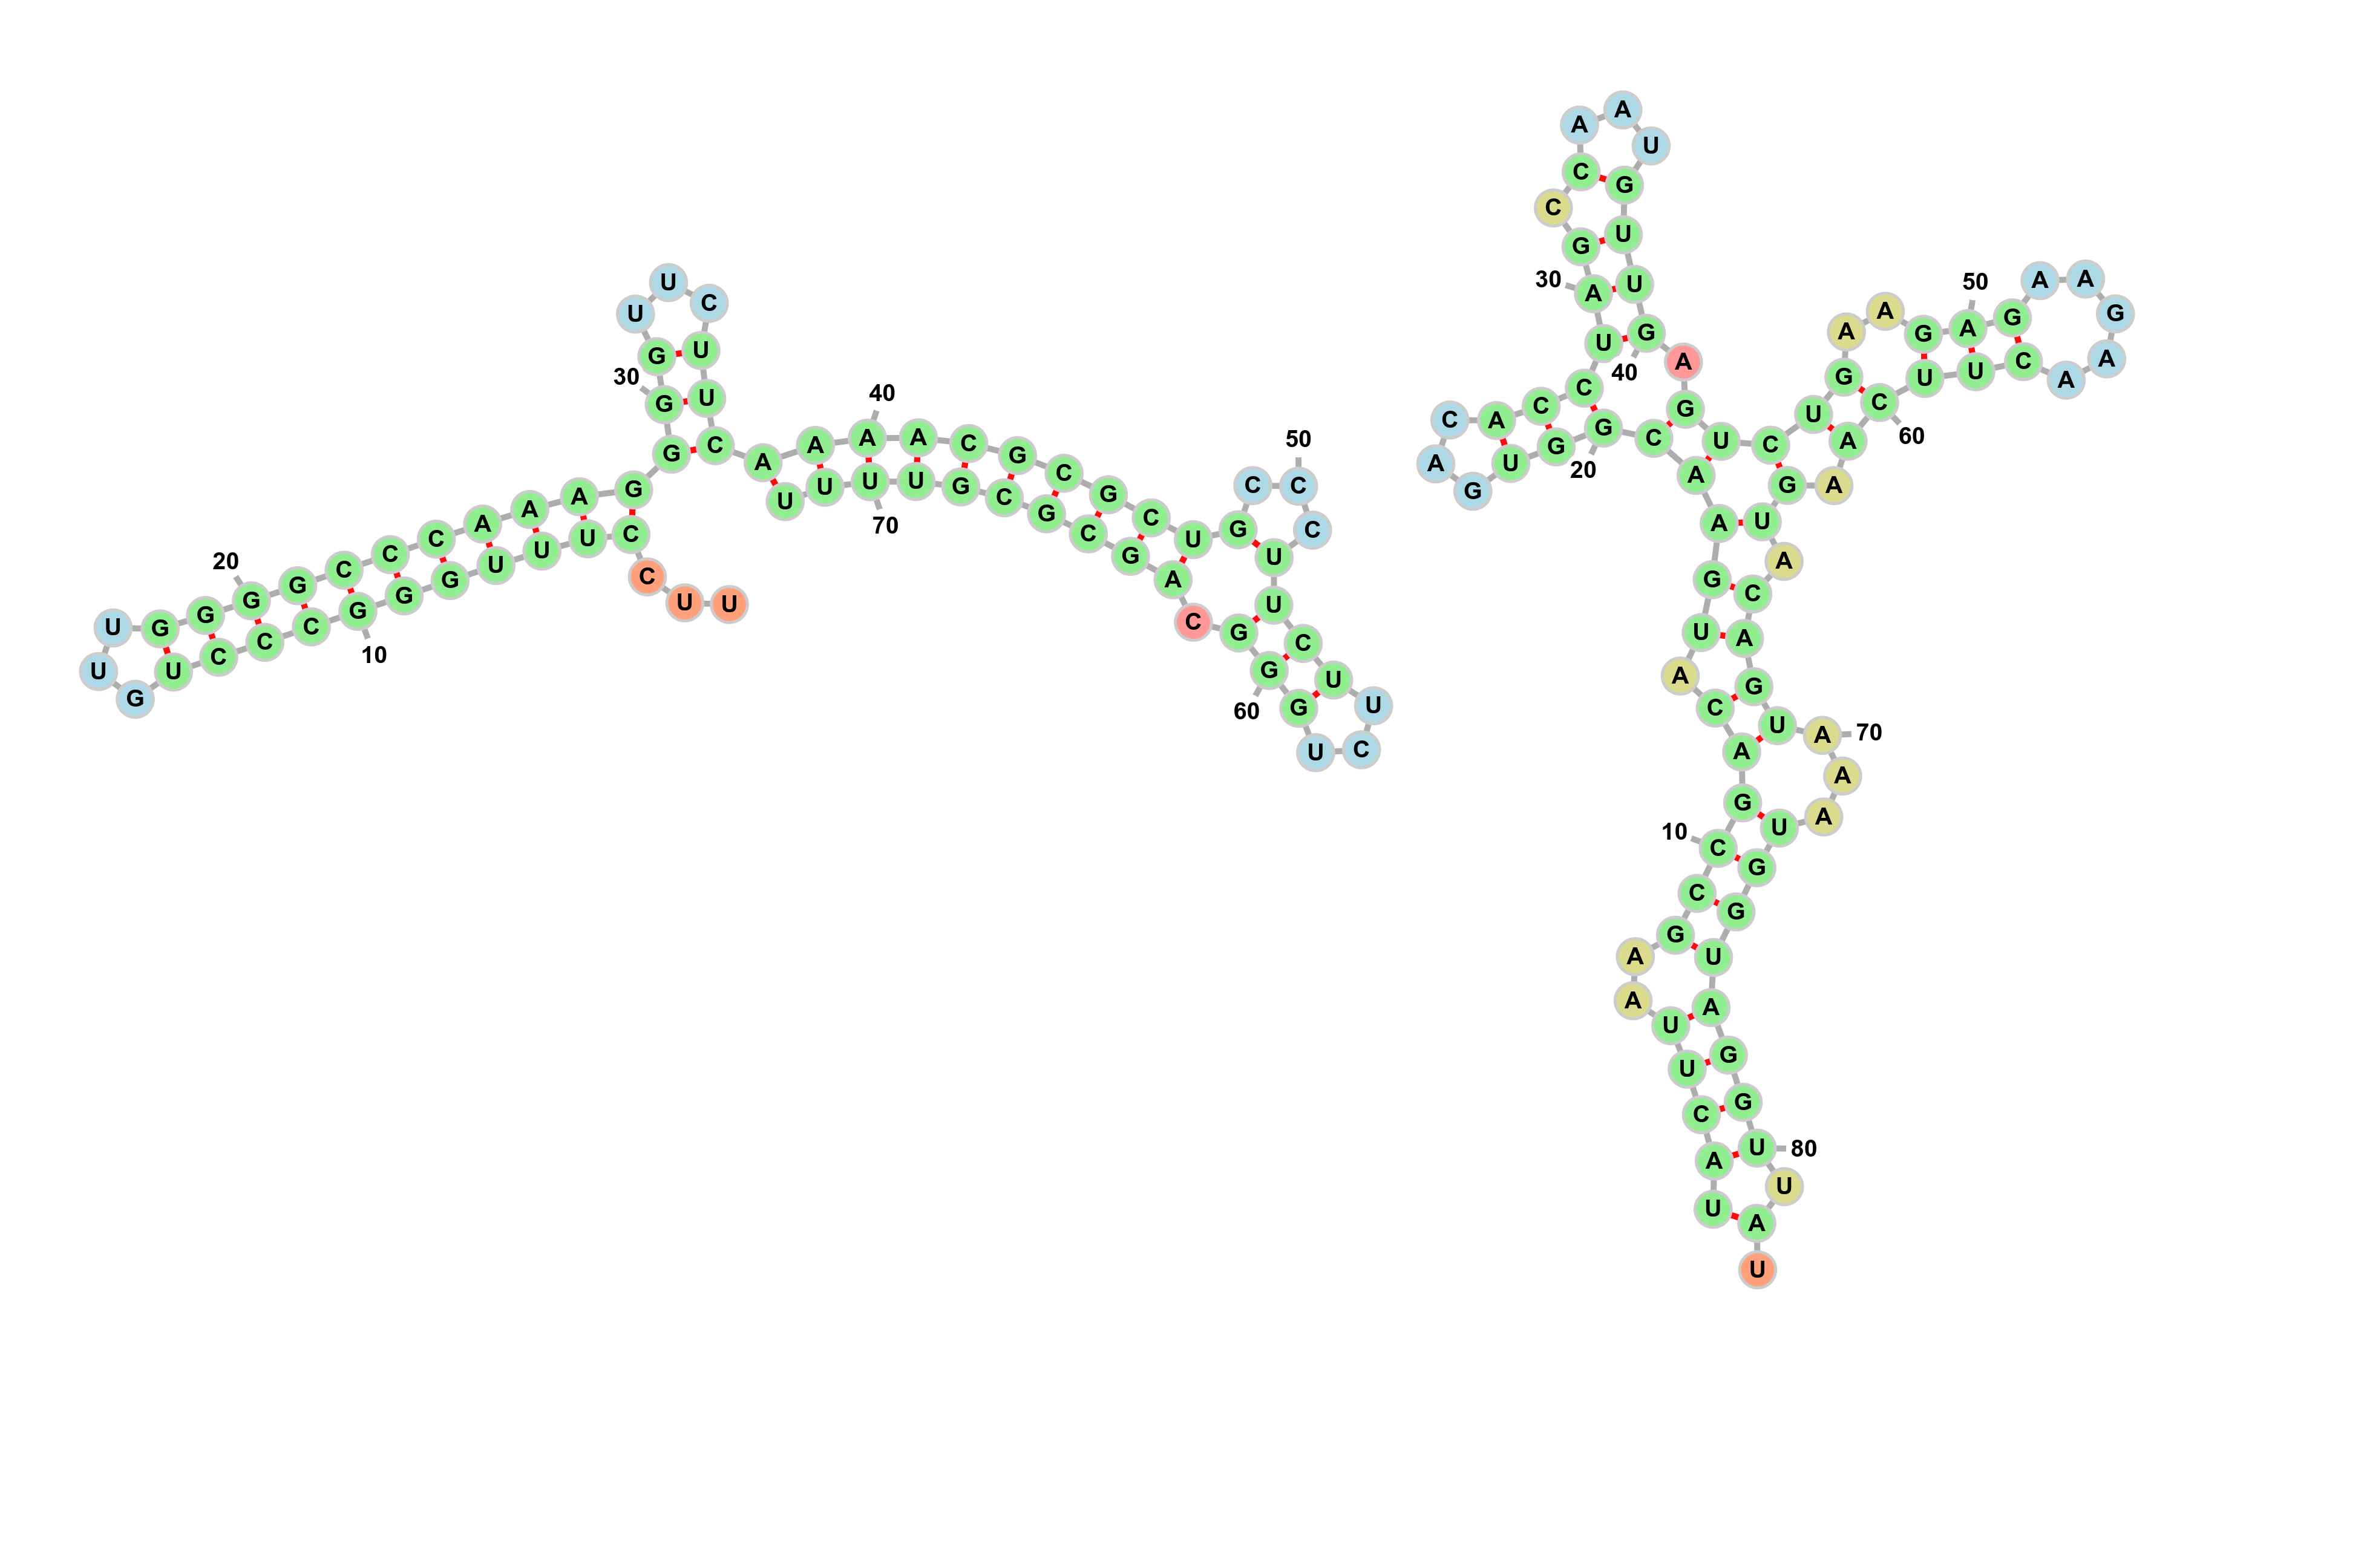

The structures predicted means we have 12 potential loop pair interactions. The Nussinov algorithm was run on all of these potential hybridizing pairs to find the number of base pairs they can make. A linker sequence of 3 unpairable nucleotides (X’s) bind together each possible interaction pair. The linker is needed to separate the two sequence parts and run the algorithm. The RNA needs to make a loop to bind to itself and we need to make sure, that this happens between the two sequence snippets. The results can be seen in the following output:

In [6]:
# Extract loop regions in the dot-bracket notation
# Use regular expression to search for loop pattern in the dot bracket notation
loop_pattern = re.compile('\(\.+\)')
loop_index_seq1 = [(m.start(0), m.end(0)) for m in re.finditer(loop_pattern, structure1)]
loop_index_seq2 = [(m.start(0), m.end(0)) for m in re.finditer(loop_pattern, structure2)]


# Loop over all possible pairs of loops
for loop1 in loop_index_seq1:
    for loop2 in loop_index_seq2:
        # Extract the interacting sequence. I.e. the two loops separated by the 3 X linker sequence
        interact_seq = seq1[loop1[0]+1:loop1[1]-1] + 'XXX' + seq2[loop2[0]+1:loop2[1]-1]
        # Compute scoring matrix for the interacting sequence
        interact_scoring = nussinov(interact_seq, minloopsize=3)
        print('Interaction between: {} and {}'.format(seq1[loop1[0]+1:loop1[1]-1], seq2[loop2[0]+1:loop2[1]-1]))
        print('Score of interaction: {}'.format(interact_scoring[0, len(interact_seq)-1]))
        # Extract the dot bracket sequence for the interacting loops
        interact_structure = backtracing(interact_scoring, interact_seq)
        print(interact_seq)
        print(interact_structure)
        print('')

Interaction between: GAC and GUU
Score of interaction: 3.0
GACXXXGUU
(((...)))

Interaction between: GAC and UUC
Score of interaction: 2.0
GACXXXUUC
((....)).

Interaction between: GAC and CCC
Score of interaction: 1.0
GACXXXCCC
(.....)..

Interaction between: GAC and UCU
Score of interaction: 2.0
GACXXXUCU
((....)).

Interaction between: AAU and GUU
Score of interaction: 3.0
AAUXXXGUU
(((...)))

Interaction between: AAU and UUC
Score of interaction: 2.0
AAUXXXUUC
((....)).

Interaction between: AAU and CCC
Score of interaction: 0.0
AAUXXXCCC
.........

Interaction between: AAU and UCU
Score of interaction: 2.0
AAUXXXUCU
((....).)

Interaction between: AAGAA and GUU
Score of interaction: 2.0
AAGAAXXXGUU
...((....))

Interaction between: AAGAA and UUC
Score of interaction: 3.0
AAGAAXXXUUC
..(((...)))

Interaction between: AAGAA and CCC
Score of interaction: 1.0
AAGAAXXXCCC
..(.....)..

Interaction between: AAGAA and UCU
Score of interaction: 3.0
AAGAAXXXUCU
.((.(...)))



The first loop on sequence 2 (GUU) binds very well with the loops on the other sequence making 3 possible base pairs with two difefrent loops (GAC and AAU) and two base pairs with the last (AAGAA). Two other loops on sequence 2 make two possible base pairs with GAC and AAU on sequence 1 and 3 base pairs with the large loop AAGAA. The last loop on sequence 2 CCC only has one possible base pair with GAC and AAGAA on sequence 1 and is therefore unlikely to hybridize with any of the loops. 

The potential to see base pairings between these loops on the two RNA molecules seem quite good with these results. There are multiple loops that can hybridize on both sequences and this means there is a good probability of the hybridization happening. A very good interaction could happen if all three loops on sequence 1 hybridize with the three loops on sequence 2. 

### Discussion

While the Nussinov algorithm does find a structure with the optimal number of base pairs, this is not necessarily the most optimal structure. That means, the optimal structure might be different from the ones found using the Nussinov, and thereby the loops used in this analysis to find interactions might not be available for interaction in the optimal structure. Instead an energy folding method could be used, which would consider the energies and could be used to find the optimal structure. In that case, we could have different interacting pairs and the interaction conclusion might then be difefrent. Another thing to keep in mind is that the structure will not necessarily reach equilibrium why a mixture of structure might be more interesting to analyse. While analysing the interactions based on multiple difefrent structures might be more accurate the ease of implementation with the method used here as well as the computational speed is very appealing. If the interaction between multiple structures were to be analysed for each pair of sequences, this could increase the computational complexity rather drastically as Nussinov has to be run for each pair of potential hybridizing regions. The simple approach here could serve as a simple analysis before applying more complex methods to explore the interactions in depth. 

### Conclusion

This notebook explored the use of Nussinov algorithm to find possible interactions between two RNA sequences. The analysis found multiple loops that can base pair and interact between the two sequences. While the approach used in this report does not consider energy folding the simple implementation makes it a powerful tool for fast analysis. 

### References

<a id="1">[1]</a> Durbin, R., Eddy, S., Krogh, A., & Mitchison, G. (1998). Biological sequence analysis: Probabilistic models of proteins and nucleic acids. *Cambridge University Press*. 

<a id="2">[2]</a> Viennarna web services - forna. (n.d.). http://rna.tbi.univie.ac.at/forna/ (accessed: 23.01.2022) 